# San Francisco Library Data 

## Business Understanding

This analysis sets out to make observations about the San Francisco Library usage and its patrons,
in the ultimate quest to find the answers to the following questions:

1. Who are frequent users of the San Francisco (SF) Library?
2. Does activity of users vary with library branch?
3. What is the average renewal rate per user?
4. Does knowing specific data about a user allow me to predict the renewal rate of that user?



In [62]:
#load libraries 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import seaborn as sns
%matplotlib inline

## Data Understanding - Part 1

In [63]:
# import DataSF dataset
df = pd.read_csv('data_raw/Library_Usage.csv');
df.head()

,Patron Type Code,Patron Type Definition,Total Checkouts,Total Renewals,Age Range,Home Library Code,Home Library Definition,Circulation Active Month,Circulation Active Year,Notice Preference Code,Notice Preference Definition,Provided Email Address,Year Patron Registered,Outside of County,Supervisor District
0,3,SENIOR,28,13,65 to 74 years,X,Main Library,November,2012,z,email,True,2003,True,NaN
1,0,ADULT,21,10,55 to 59 years,X,Main Library,October,2015,z,email,True,2003,False,NaN
2,0,ADULT,275,559,60 to 64 years,X,Main Library,January,2015,z,email,True,2003,True,NaN
3,0,ADULT,73,38,45 to 54 years,M8,Mission Bay,February,2016,z,email,True,2003,False,NaN
4,0,ADULT,182,90,45 to 54 years,X,Main Library,July,2016,z,email,True,2003,False,NaN


### How much data it there  and what data do I have to work with?

In [64]:
#423448 records to start
df.shape

(423448, 15)

In [65]:
# What are the types of data do we have to work with?
df.dtypes

Patron Type Code                  int64
Patron Type Definition           object
Total Checkouts                   int64
Total Renewals                    int64
Age Range                        object
Home Library Code                object
Home Library Definition          object
Circulation Active Month         object
Circulation Active Year          object
Notice Preference Code           object
Notice Preference Definition     object
Provided Email Address             bool
Year Patron Registered            int64
Outside of County                  bool
Supervisor District             float64
dtype: object

### Initial Findings
Looks like there is a lot of user information to sift through (423,448 records), but the type of data available for each user is minimal (only 15 columns). 

For each user, Patron Type, Home Library, Age Range, and Supervisor District could be useful data to group users and find trends. 

Total Checkouts, Total Renewals, and Circulation Acitve Year are also provided which will help in finding out about activity of a user and per library usage. 

There are three repetative columns: Patron Type Code, Home Library Code, and Notice Preference Code 

Also looks like some data is not in the ideal format. For example, age per user is only provided as a range which greatly affects the accuracy of using it for modeling because it is unknown if there is large variance within an age range. The data set also does not provide any information about the type of book most frequently checked out by a user, dates of checkouts, or provide a definition for the patron types available. 

### User Information

Let's take a closer look at the information available that might help in categorizing a user:
 * Patron Type Definition
 * Age Range
 * Home Library Definition
 * Supervisor District

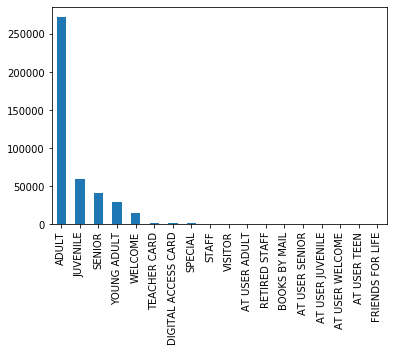

In [66]:
df['Patron Type Definition'].value_counts().plot(kind = 'bar');

I can already see that Patron Type is not a variable I want to move forward with. The majority of users fall into adult, juvenile, young adult, and senoir type which are all categories that are better defined by the age range variable. 

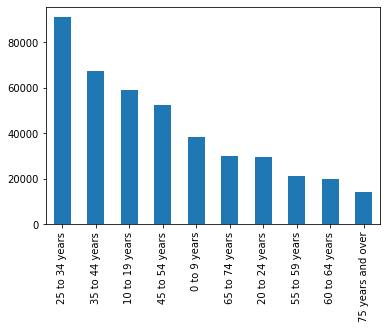

In [67]:
df['Age Range'].value_counts().plot(kind = 'bar');

Age Range is a much better fit than Patron Type as it is more understandable and there is significant variation amoungst users. 

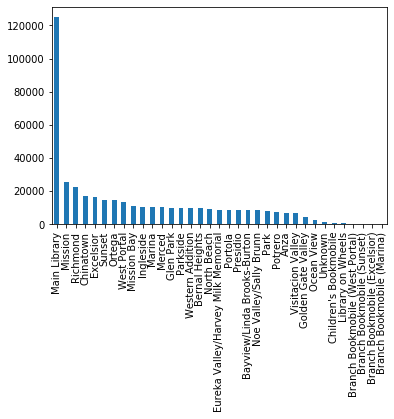

In [68]:
df['Home Library Definition'].value_counts().plot(kind = 'bar');

It's clear from the above that the Main Library branch greatly outpaces other branches in terms of number of users. 
However, there is still a significant number of users at the other branches that could lead to some findings about activity. However, this does answer one of my initial questions, does usage vary by library branch? -- YES

It is also clear that the mobile libraries get insignificant traffic compared to non-mobile and it is reasonable to leave these branches out of future analysis. 

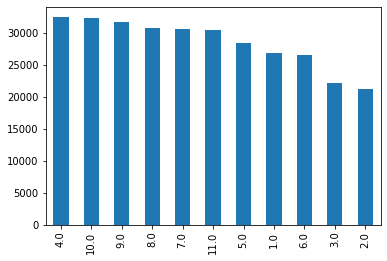

In [69]:
df['Supervisor District'].value_counts().plot(kind = 'bar');

Although not directly related to library usage, supervisor district is provided in the data set and could prove to uncover some hiddend insights between where a user lives and which library they use. I am not sure if this has any real impact on the activity of a user and if it did, I am not sure how I would prove causation versus correlation. It might still be interesting to see if users from different districts align with certain library branches as both variables are dependent on location.  

In [70]:
# make new dataframe to hold data by district and library
df_sup_lib = df.groupby(['Supervisor District', 'Home Library Definition'])['Total Checkouts'].count().reset_index()

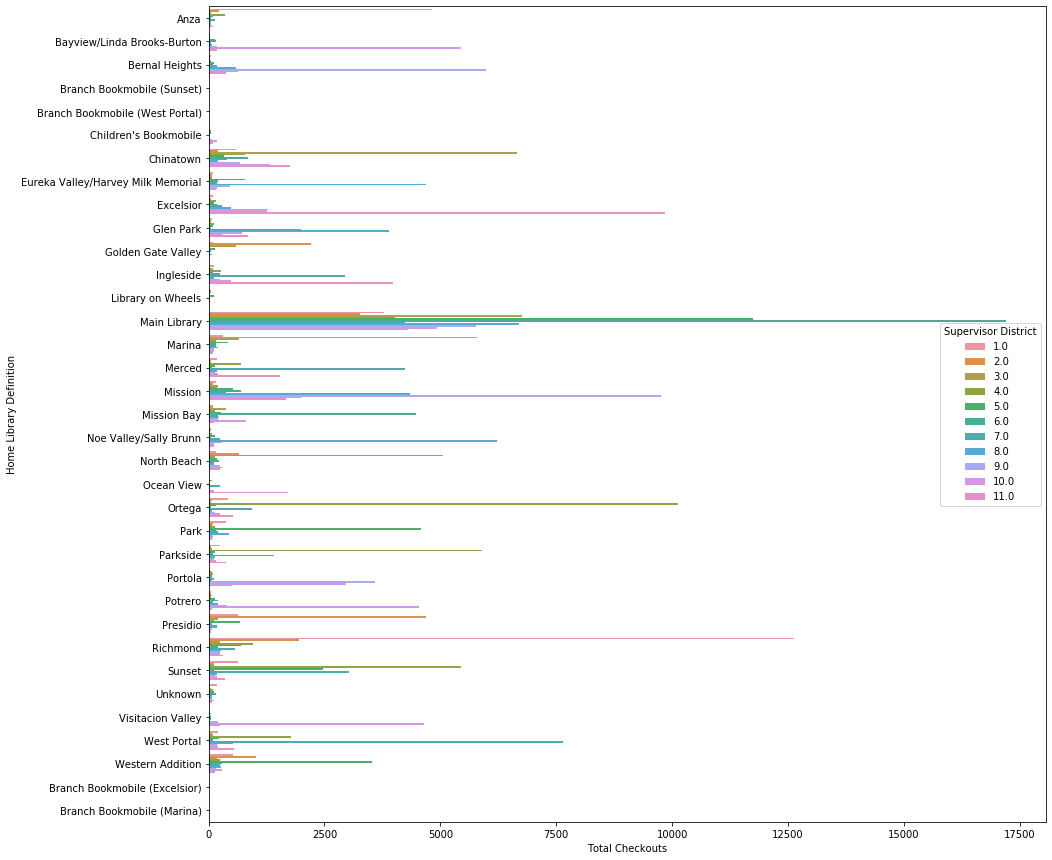

In [71]:
plt.figure(figsize = (15,15));
sns.barplot(data =df_sup_lib
            ,x = 'Total Checkouts'
            ,y = 'Home Library Definition'
            ,hue = 'Supervisor District'
            ,ci = None
            );

Looks like for each library branch, there  consistently a large set of users that belong to one District. This let's me know that the home library branch can be somewhat used a surrogate for a users location/district. The exception to this are the mobile libraries, which don't have much information on District. This graph also uncovers that there is an 'Unknown' library which will have to be dropped from the dataset before further analysis.

### Activity Data

Some of the numerical data can also provide insights to my questions, specifically:
 * Total Checkouts
 * Total Renewals


Let's take a look at the spread of these variables within the data

In [72]:
df.describe()

,Patron Type Code,Total Checkouts,Total Renewals,Year Patron Registered,Supervisor District
count,423448.000000,423448.000000,423448.000000,423448.000000,313138.000000
mean,1.036765,161.982097,59.657327,2010.348917,6.288240
std,4.188198,453.703678,225.009917,4.357374,3.123634
min,0.000000,0.000000,0.000000,2003.000000,1.000000
25%,0.000000,2.000000,0.000000,2007.000000,4.000000
50%,0.000000,19.000000,2.000000,2012.000000,6.000000
75%,1.000000,113.000000,27.000000,2014.000000,9.000000
max,104.000000,35907.000000,8965.000000,2016.000000,11.000000


First thing I spot is that Patron Type and Supervisor District are miscategorized as integer type data when they should be categorical. This is the same for Circulation Active Year, it does not show up here becuase it is not categorized as an integer.

Looking at total renewals, the minimum renewals is zero, but this is reasonable considering there are some users who haven't checked out any books! What really catches my eye is the variance in Total Checkouts and Total Renewals: 0 - 35,000 and 0 to 9,000, respectively. Whereas the average of these columns is more around 450 and 225. That tells me that there may be some very active users and non-active users that may skew the data and I may have to exclude these as outliers. This is also a start to answering my first question of Who are frequent users of the library?

### Temporal Data

The third type of data is temporal.

 * Year Patron Registered
 * Circulation Active Year
 
From my previous looks at the data, there is no breakdown of a users checkout data or renewal data on yearly basis so I will have to create new variables that average over the years active. 


In [73]:
df['Year Patron Registered'].value_counts()

2003    69257
2015    53951
2014    51902
2013    48251
2012    37395
2011    26531
2016    26288
2010    24321
2009    22307
2008    20518
2007    13289
2006    10776
2005     9668
2004     8994
Name: Year Patron Registered, dtype: int64

In [74]:
df['Circulation Active Year'].value_counts()

2016    147901
2015     79623
None     67904
2014     63502
2013     43722
2012      9571
2011      3108
2010      2975
2009      1820
2008      1244
2007       710
2006       567
2005       498
2004       297
2003         6
Name: Circulation Active Year, dtype: int64

For both variables the years span from 2003 to 2016. It also looks like the library has a growing number of active users, which is always a good sign for any business. If I were more interested in the library as a business, I might delve deeper into this data to see if I can determine a retention rate. But for my purposes, I am more interested in the years a user is active so that I can determine if this affect their total checkouts. 

I also see that there is significant number of users that have a Circulation Active Year of None. This will affect my analysis because the years active is directly correlated to how many books a person has checked out and the amount of renewals that user has used. If I cannot determine this, I need to drop these observations. 


### Missing Data

For both categorical and numerical data, any missing data could have an affect on my findings. Therefore, I want to know which data, if any needs to be imputed or dropped from the set before delving any further.

In [75]:
# Is there any missing data?
df.isnull().sum()

Patron Type Code                     0
Patron Type Definition               0
Total Checkouts                      0
Total Renewals                       0
Age Range                          215
Home Library Code                   40
Home Library Definition              0
Circulation Active Month             0
Circulation Active Year              0
Notice Preference Code               0
Notice Preference Definition         0
Provided Email Address               0
Year Patron Registered               0
Outside of County                    0
Supervisor District             110310
dtype: int64

Superviser District has significant amount of missing data (~30%). This tells me that I cannot move forward with using this as a variable in my model or analysis without either imputing or dropping. Luckly, from my previous analysis, I found that the home library branch data can be used as a surrogate for the district so I am comfortable not using this data as a part of my analysis. 

### Rephrase of Questions
Having taken a better look at the data, I can now rephrase my initial questions to better fit the data I have.

1. How does library activity vary by age range
2. Which library branch has the most traffic?/ the least?
3. What is the average renewal rate? Does this vary per age range? per library branch?
4. Does knowing a users age range, total checkouts, years active allow me to predict the renewal rate of that user?


# Prepare Data

From my look at the data, I now know that I should do the following to prep the data from modeling:

    1. Change header names to exclude spaces
    2. Drop columns that are codified versions of other columns (duplicate info)
    3. Due to the siginifcant % of missing values in the Supervisor District attribute, drop this column. 
    4. Change Circulation Active Year to data type int. 
    5. Determine whether nonsensical values exist in other categorical attributes
    6. Total checkouts and renewals have a large impact on my results, therefore I will need to determine whether
    outliers exist and what should be done with these outliers. 
    7. Create new variables to represent activity: years_active, renewal_rate, yearly_renewals, yearly_checkouts

### 1. Normalize column names 

In [76]:
df.columns = df.columns.str.replace(' ', '_').str.lower()
df.head()

,patron_type_code,patron_type_definition,total_checkouts,total_renewals,age_range,home_library_code,home_library_definition,circulation_active_month,circulation_active_year,notice_preference_code,notice_preference_definition,provided_email_address,year_patron_registered,outside_of_county,supervisor_district
0,3,SENIOR,28,13,65 to 74 years,X,Main Library,November,2012,z,email,True,2003,True,NaN
1,0,ADULT,21,10,55 to 59 years,X,Main Library,October,2015,z,email,True,2003,False,NaN
2,0,ADULT,275,559,60 to 64 years,X,Main Library,January,2015,z,email,True,2003,True,NaN
3,0,ADULT,73,38,45 to 54 years,M8,Mission Bay,February,2016,z,email,True,2003,False,NaN
4,0,ADULT,182,90,45 to 54 years,X,Main Library,July,2016,z,email,True,2003,False,NaN


### 2. De-duplicate

In [77]:
#de-duplicate by dropping codified columns:
df.drop(['home_library_code','notice_preference_code', 'patron_type_code'], axis =1,inplace = True)
df.head()


,patron_type_definition,total_checkouts,total_renewals,age_range,home_library_definition,circulation_active_month,circulation_active_year,notice_preference_definition,provided_email_address,year_patron_registered,outside_of_county,supervisor_district
0,SENIOR,28,13,65 to 74 years,Main Library,November,2012,email,True,2003,True,NaN
1,ADULT,21,10,55 to 59 years,Main Library,October,2015,email,True,2003,False,NaN
2,ADULT,275,559,60 to 64 years,Main Library,January,2015,email,True,2003,True,NaN
3,ADULT,73,38,45 to 54 years,Mission Bay,February,2016,email,True,2003,False,NaN
4,ADULT,182,90,45 to 54 years,Main Library,July,2016,email,True,2003,False,NaN


### 3. Drop Supervisor District column because Home Library can be used as surrogate and has less missing data

In [78]:
# 3. Drop the supervisor district column
df.drop(['supervisor_district'], axis =1,inplace = True)

### 4. Impute or Drop Missing Data
As seen before, some Circulation Active Years have a value of None. Before dropping this column, I want to determine if there are any other categorical variable that also have nonsensical vlaues and the % of each that fall into this bucket. In short I want to consider the following for each categorical variable:  
    **Required** =  relevance to questions posed  
    **Feasibility of Replacement** = % missing values  



In [79]:
#look at all values available for each categorical variable to determine if there are nonsensical values
for i in df.columns:
    if df[i].dtype == 'object':
        print(df[i].value_counts().sort_values());

FRIENDS FOR LIFE           40
AT USER TEEN               44
AT USER WELCOME            45
AT USER JUVENILE           47
AT USER SENIOR             66
BOOKS BY MAIL              95
RETIRED STAFF             157
AT USER ADULT             349
VISITOR                   415
STAFF                     862
SPECIAL                   977
DIGITAL ACCESS CARD      1744
TEACHER CARD             1782
WELCOME                 14931
YOUNG ADULT             28816
SENIOR                  41619
JUVENILE                59208
ADULT                  272251
Name: patron_type_definition, dtype: int64
75 years and over    14150
60 to 64 years       19800
55 to 59 years       21230
20 to 24 years       29761
65 to 74 years       30141
0 to 9 years         38242
45 to 54 years       52492
10 to 19 years       58944
35 to 44 years       67390
25 to 34 years       91083
Name: age_range, dtype: int64
Branch Bookmobile (Marina)                 7
Branch Bookmobile (Excelsior)             23
Branch Bookmobile (Sunset) 

From above, it looks like a few other attributes have either a value of 'None' or 'Unknown', which I would considered as missing data. The data most pertinent to answering my questions are **age_range, year registered, circulation_active_year, and home library definition**. I want to know just how much missing data is present in each of these columns.

In [80]:
# cycle through each categorical column to determine percent missing data 
for i in df.columns:
    if df[i].dtype == 'object':
        print(i)
        print((df[i][df[i]== 'None']).count()/df.shape[0])


patron_type_definition
0.0
age_range
0.0
home_library_definition
0.0
circulation_active_month
0.16035971358938997
circulation_active_year
0.16035971358938997
notice_preference_definition
0.0


In [81]:
for i in df.columns:
    if df[i].dtype == 'object':
        print(i)
        print((df[i][df[i]== 'Unknown']).count()/df.shape[0])

patron_type_definition
0.0
age_range
0.0
home_library_definition
0.003537624454478472
circulation_active_month
0.0
circulation_active_year
0.0
notice_preference_definition
0.0


**Circulation_active_year** and **circualtion_active_month** have the highest percent missing at ~16% whereas other columns missing value counts are fairly minimal when compared to entire dataset. 
I do not think I have enough information to impute these values, nor do I think that dropping these observations will have a large impact on my analysis, so I am going to drop these observations from the data.

In [82]:
#drop observations with with missing data
df_comp = df[df.circulation_active_year != 'None']
df_comp = df_comp[df_comp.home_library_definition != 'Unknown']
df_comp = df_comp[df_comp.notice_preference_definition != 'none']

In [83]:
#double check for nonsensical values
print(df_comp.circulation_active_year[df_comp.circulation_active_year == 'None'].count()) #year
print(df_comp.circulation_active_month[df_comp.circulation_active_month == 'None'].count()) #month
print(df_comp.home_library_definition[df_comp.home_library_definition== 'Unknown'].count()) # library_def
print(df_comp.notice_preference_definition[df_comp.notice_preference_definition == 'none'].count())# notice

0
0
0
0


After dropping the missing values, my dataset now has the following number of observations

In [84]:
df_comp.shape

(354203, 11)

I have now cleaned up **circulation_active Year, year_registered, and home_library_branch**, but I didn't see anything out of place in **age_range**. However, when looking through the data earlier, I did see some _null_ values in this column. Again, I do not feel I have enough information to impute this for a user so I am going to drop it from my set.

In [85]:
# drop na age_range values and re-check for null values
df_comp.dropna(subset = ['age_range'], axis = 0, inplace = True)
df_comp.isnull().sum()

patron_type_definition          0
total_checkouts                 0
total_renewals                  0
age_range                       0
home_library_definition         0
circulation_active_month        0
circulation_active_year         0
notice_preference_definition    0
provided_email_address          0
year_patron_registered          0
outside_of_county               0
dtype: int64

That took me down about 130 records

In [86]:
df_comp.shape

(354077, 11)

### 5. Change the data type of circulation_active_year to int so that is no longer considered categorical

In [87]:
df_comp = df_comp.astype({"circulation_active_year": int});
df_comp.dtypes

patron_type_definition          object
total_checkouts                  int64
total_renewals                   int64
age_range                       object
home_library_definition         object
circulation_active_month        object
circulation_active_year          int64
notice_preference_definition    object
provided_email_address            bool
year_patron_registered           int64
outside_of_county                 bool
dtype: object

### Create Activity Data Variables
Now that I have really delved into the data, I know that I don't want to consider users who have never used the library. These users have no checkout data and therefore no renewal data and end up skewing the data in a way that I think is irrelevant to the questions posed. 

In [88]:
# drop 0 checkout rows
df_comp = df_comp[df_comp.total_checkouts != 0]

I also realized that it would be unfair to consider the total renewals or total checkouts of a user without considering the years they have been active. Since the data only spans from 2003 to 2016 some users may have jsut signed up in 2016 and have not had a chance to rack up checkouts. However, I don't want to exclude these new users if they have checkouts. In order to calculated yearly averages, I am going to be less conservative and give each user with checkouts at least 1 year active. 

In [89]:
#create years_active
df_comp['years_active'] = (df_comp.circulation_active_year- df_comp.year_patron_registered)+1


In [90]:
#create yearly checkouts based on years_active
df_comp["yearly_checkouts"] = np.round(df_comp.total_checkouts/df_comp.years_active)


In [91]:
# For the above, there is a definite dip in library usage starting from early 20s to mid 40s age_range. 
# Then a steady climb from there. But still, the oldest members have the highest average checkouts per years active. 
# What about renewals? Because renewals are directly related to checkouts, this look relatively the same as the graph above. 
df_comp['yearly_renewals'] = np.round(df_comp.total_renewals/df_comp.years_active,0)

In [92]:
# Interesting, when looking at renewals the highest group is not 60-64 years and the 75 and older is brought 
# down to fifth highest.
# Let's take a look at renewals per checkouts. Because the data does not provide specifics about any particular
# checkout, this again will have to be computed as an average=
# total_renewals/ total_checkouts 
df_comp['renewal_rate'] = np.round(df_comp.total_renewals/df_comp.total_checkouts,1)

I also noticed in my graphs and tables earlier that the results for age_range are hard to interpret because the age_ranges are not ordered. I want anything having to do with the age_range to following the needed ranking so I am going to make this variable a category data type.

In [93]:
# make age range into a categorial data type so graphical representations can be order by age_range
from pandas.api.types import CategoricalDtype
age_cat = CategoricalDtype(categories=["0 to 9 years", "10 to 19 years", "20 to 24 years",
                                       "25 to 34 years", "35 to 44 years", "45 to 54 years",
                                      "55 to 59 years", "60 to 64 years","65 to 74 years", "75 years and over" ], ordered=True)
df_comp.age_range = df_comp.age_range.astype(age_cat)

### 6. Assess outliers

In [94]:
df_comp.describe()

,total_checkouts,total_renewals,circulation_active_year,year_patron_registered,years_active,yearly_checkouts,yearly_renewals,renewal_rate
count,348404.000000,348404.000000,348404.000000,348404.000000,348404.000000,348404.000000,348404.000000,348404.000000
mean,195.764406,72.081428,2014.735864,2009.586569,6.149295,24.589557,8.462363,0.422670
std,492.226796,245.452735,1.562371,4.351054,4.451930,48.822362,23.160767,0.637664
min,1.000000,0.000000,2003.000000,2003.000000,1.000000,0.000000,0.000000,0.000000
25%,7.000000,0.000000,2014.000000,2005.000000,2.000000,3.000000,0.000000,0.000000
50%,35.000000,6.000000,2015.000000,2010.000000,5.000000,8.000000,1.000000,0.200000
75%,158.000000,41.000000,2016.000000,2013.000000,10.000000,25.000000,7.000000,0.600000
max,35907.000000,8965.000000,2016.000000,2016.000000,14.000000,2565.000000,640.000000,9.000000


From above, I can clearly see there are some outliers in the yearly_checkouts, yearly_renewals, and renewal_rate columns

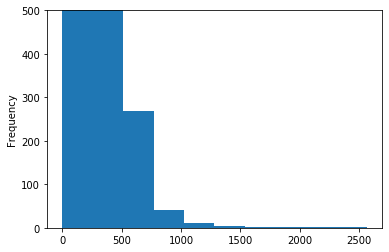

In [95]:
df_comp.yearly_checkouts.plot(kind = 'hist', ylim = [0,500]);

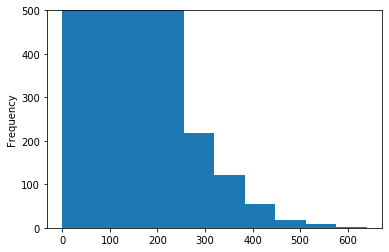

In [96]:
df_comp.yearly_renewals.plot(kind = 'hist', ylim = [0,500]);


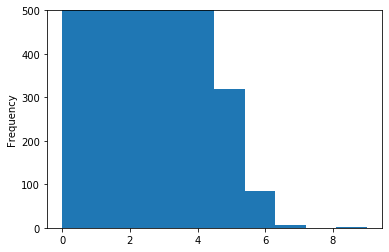

In [97]:
df_comp.renewal_rate.plot(kind = 'hist', ylim = [0,500]);


From the above it looks like yearly checkouts above 1000, yearly renewals above 500 are rare, and renewal_rates above 6 are rare. I will consider anything above these values in each respective data sets as outliers due their low frequency.

In [98]:
# get rid of outliers
df_comp = df_comp[df_comp.yearly_checkouts <= 1000]
df_comp = df_comp[df_comp.yearly_checkouts <= 500]
df_comp = df_comp[df_comp.yearly_checkouts <= 6]

## Data Understanding - Part II

Now that I have created new data, I want to take a second look using these new variables and then re-prep the data accordingly.

Let's take a look at the yearly_checkouts across age_range

In [99]:
df_comp.groupby('age_range').yearly_checkouts.describe()

,count,mean,std,min,25%,50%,75%,max
age_range,,,,,,,,
0 to 9 years,9396.0,3.198702,1.784387,0.0,2.0,3.0,5.0,6.0
10 to 19 years,17721.0,2.888607,1.776510,0.0,1.0,3.0,4.0,6.0
20 to 24 years,13801.0,2.412434,1.700265,0.0,1.0,2.0,4.0,6.0
25 to 34 years,43806.0,2.519678,1.730109,0.0,1.0,2.0,4.0,6.0
35 to 44 years,26933.0,2.719600,1.780574,0.0,1.0,2.0,4.0,6.0
45 to 54 years,19347.0,2.676591,1.799575,0.0,1.0,2.0,4.0,6.0
55 to 59 years,7608.0,2.597660,1.790655,0.0,1.0,2.0,4.0,6.0
60 to 64 years,6837.0,2.609478,1.767800,0.0,1.0,2.0,4.0,6.0
65 to 74 years,9870.0,2.607194,1.800747,0.0,1.0,2.0,4.0,6.0


In [100]:
df_comp.groupby('age_range').renewal_rate.describe()

,count,mean,std,min,25%,50%,75%,max
age_range,,,,,,,,
0 to 9 years,9396.0,0.119200,0.368651,0.0,0.0,0.0,0.0,6.5
10 to 19 years,17721.0,0.181937,0.422581,0.0,0.0,0.0,0.2,6.0
20 to 24 years,13801.0,0.453185,0.811670,0.0,0.0,0.0,0.6,8.5
25 to 34 years,43806.0,0.637340,0.906849,0.0,0.0,0.2,1.0,7.0
35 to 44 years,26933.0,0.537523,0.789201,0.0,0.0,0.2,0.8,6.7
45 to 54 years,19347.0,0.438667,0.688164,0.0,0.0,0.1,0.6,9.0
55 to 59 years,7608.0,0.434556,0.666881,0.0,0.0,0.1,0.6,6.0
60 to 64 years,6837.0,0.433523,0.645355,0.0,0.0,0.2,0.6,6.0
65 to 74 years,9870.0,0.394732,0.622587,0.0,0.0,0.1,0.5,7.0


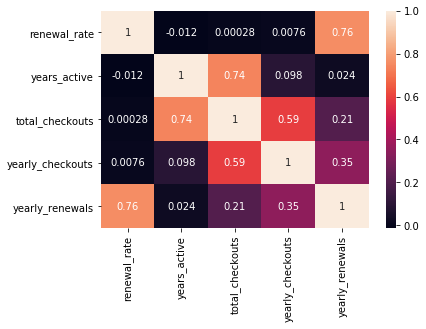

In [103]:
sns.heatmap(df_comp[['renewal_rate','years_active', 'total_checkouts', 'yearly_checkouts', 'yearly_renewals']].corr(), annot = True);

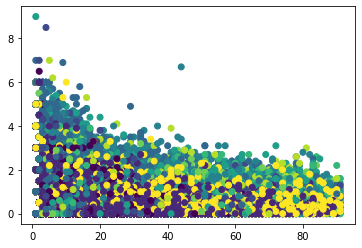

In [104]:
#PLOTS
plt.scatter(x = df_comp.total_checkouts, y = df_comp.renewal_rate.multiply(2*0.5).round(1)
            , c= df_comp.age_range.cat.codes)


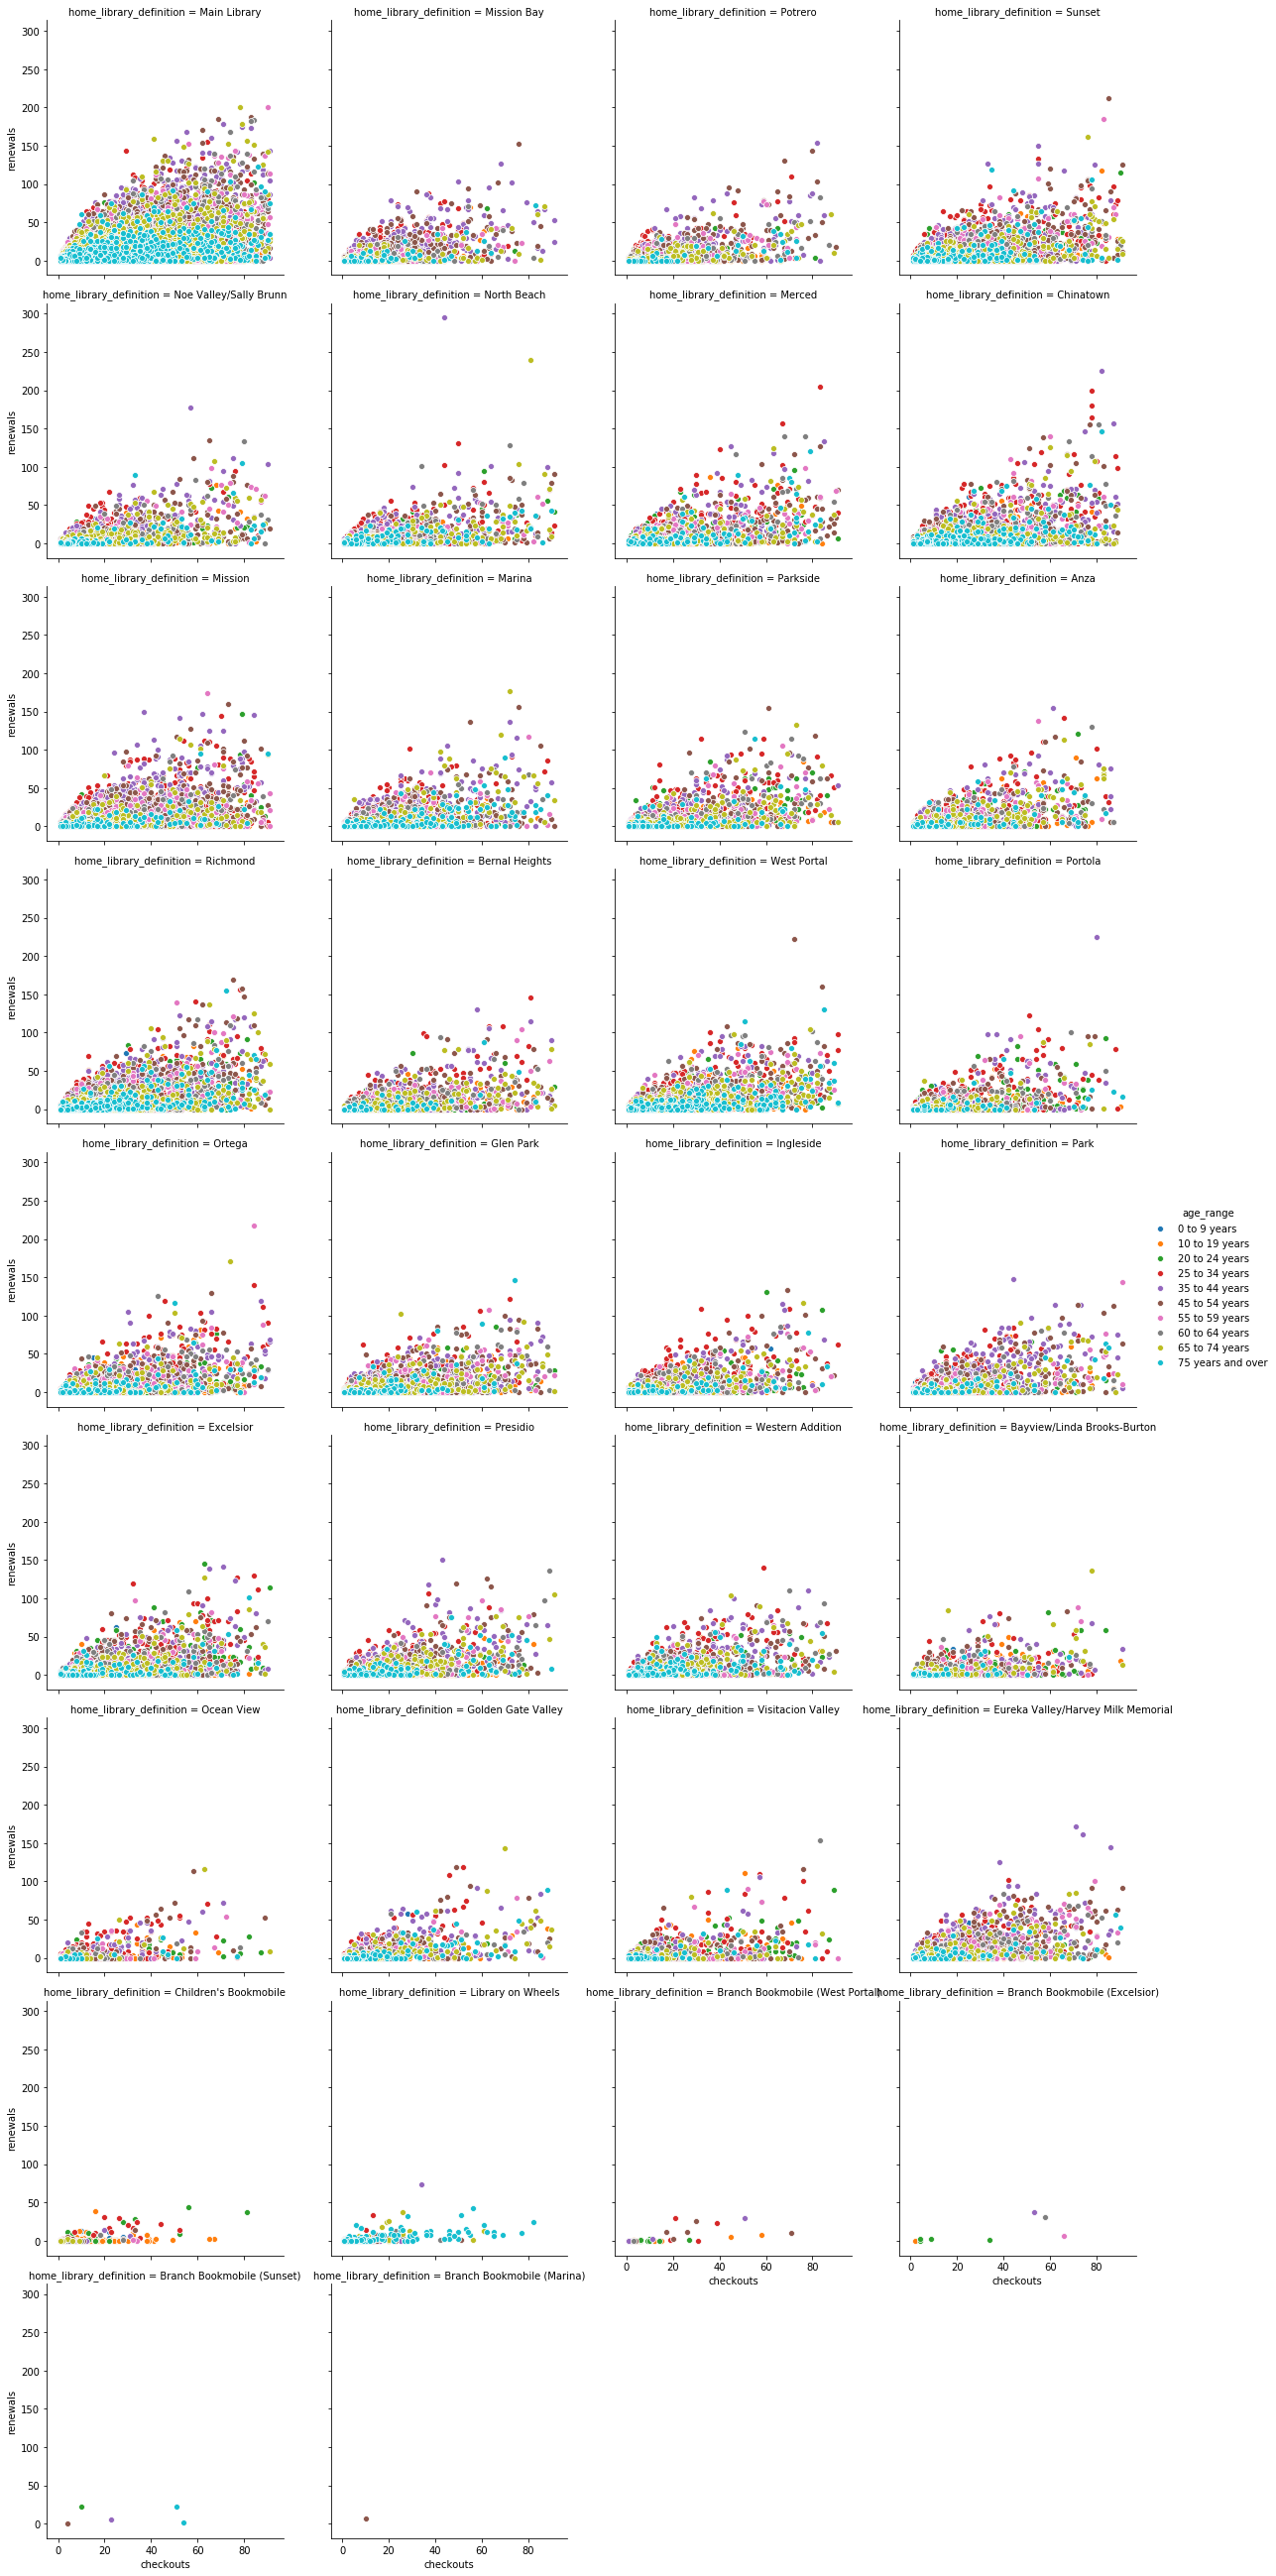

In [105]:
plt1 = sns.FacetGrid(df_comp, col="home_library_definition", hue="age_range", height = 4, col_wrap=4);
plt1.map_dataframe(sns.scatterplot, x="total_checkouts", y="total_renewals");
plt1.set_axis_labels("checkouts", "renewals");
plt1.add_legend();

## Analyze
Now that I have a cleaned up data set I can take a better look at the data and start answering some of my questions.

    

Which library has the highest usage/traffic?

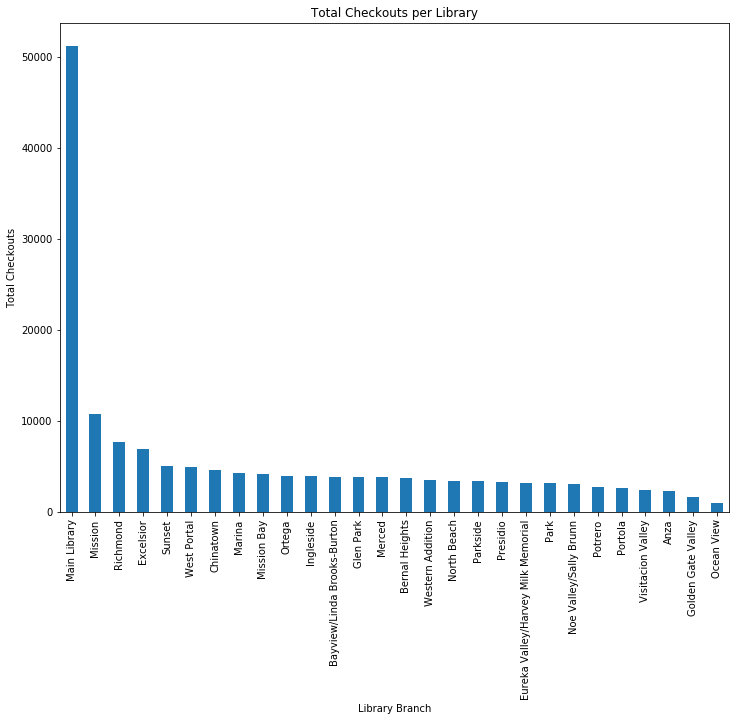

In [106]:
# Main Library for the win. 
# Makes sense, the main library is where most library events go down and has the largest selection of books.
plt.figure(figsize = (12,9));
(df_comp.groupby('home_library_definition').total_checkouts.count().sort_values(ascending = False))[:28].plot(kind = 'bar');
plt.title('Total Checkouts per Library');
plt.xlabel("Library Branch");
plt.ylabel('Total Checkouts');
plt.savefig('ActiveBranch.jpeg', bbox_inches = 'tight' );

Does activity vary by age range?

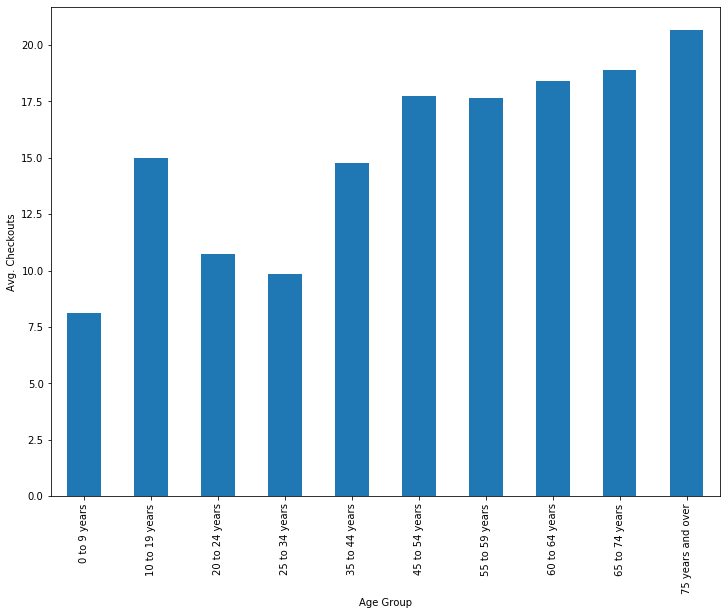

In [107]:
plt.figure(figsize = (12,9));
df_comp.groupby('age_range').total_checkouts.mean().plot(kind = 'bar')
plt.xlabel('Age Group');
plt.ylabel('Avg. Checkouts');
plt.savefig('CheckoutsperAge.jpeg', bbox_inches = 'tight' );


At first glance, it looks like, for the most part,the older the patron, the more checkouts.
but this could also be a function of how many years a patron has been active
Therefore, to get a real gauge of which age group really checks out the most books
I want to compute the average checkouts/years active 
assuming the current year is 1 yr more than the maximum year noted in the dataset

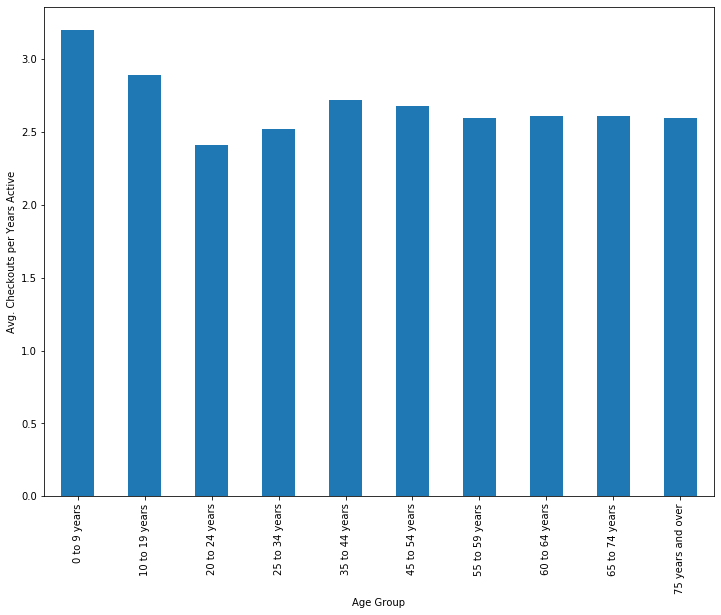

In [108]:
plt.figure(figsize = (12,9));
df_comp.groupby('age_range').yearly_checkouts.mean().plot(kind ='bar');
plt.xlabel('Age Group');
plt.ylabel('Avg. Checkouts per Years Active');
plt.savefig('YearlyCheckoutsperAge.jpeg', bbox_inches = 'tight' );

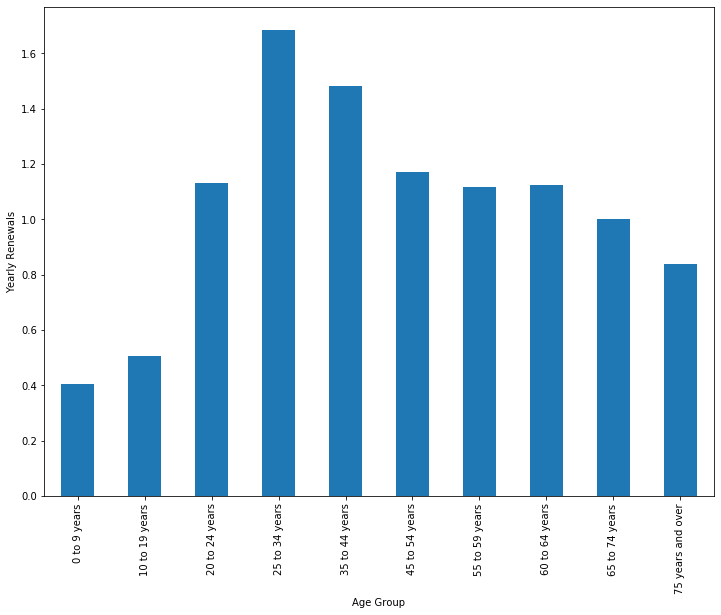

In [109]:
plt.figure(figsize = (12,9));
df_comp.groupby('age_range').yearly_renewals.mean().plot(kind ='bar');

#plt.title('Avg. Yearly Renewals');
plt.xlabel('Age Group');
plt.ylabel('Yearly Renewals');
plt.savefig('YearlyRenewalsperAge.jpeg', bbox_inches = 'tight' );

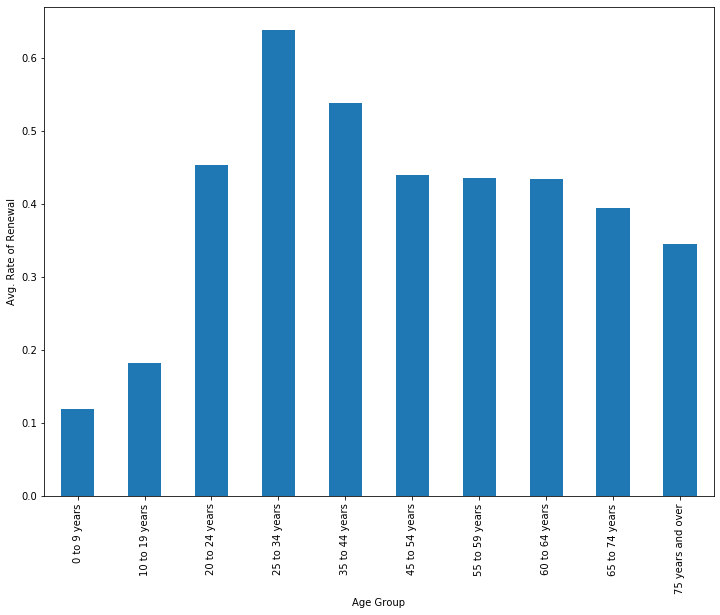

In [110]:


plt.figure(figsize = (12,9));
df_comp.groupby('age_range').renewal_rate.mean().plot(kind ='bar');
plt.xlabel('Age Group');
plt.ylabel('Avg. Rate of Renewal');
plt.savefig('RenewalRateperAge.jpeg', bbox_inches = 'tight' );

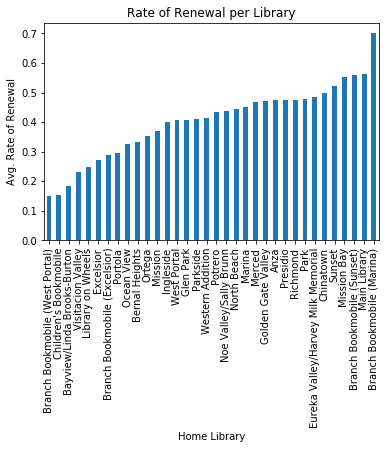

In [111]:
# ok so now I know that if the book has been checked out by a 20 something, I might have to wait an average of 2 - 9 days 
# more than if any other age group has the group
# how does home_library affect this?
df_comp.groupby('home_library_definition').renewal_rate.mean().sort_values().plot(kind = 'bar');
plt.xlabel ('Home Library');
plt.ylabel('Avg. Rate of Renewal');
plt.title('Rate of Renewal per Library');

## Model

Lastly, I want to know if there is any way to predict a users renewal rate based on their yearly_checkouts, years_active, total_renewals, age_range, and home library branch.

From my previous look into the data, I can tell that there is no strong correlation any one of these variable and the renewal rate, alone. However, maybe there is a correlation between multiple?

In order to fit to the categorical variables, home library branch and age_range,I have to create dummy booleans. For this I will use the following function:

In [114]:
def create_dummy_df(df, cat_cols, dummy_na):
    '''
    INPUT:
    df - pandas dataframe with categorical variables you want to dummy
    cat_cols - list of strings that are associated with names of the categorical columns
    dummy_na - Bool holding whether you want to dummy NA vals of categorical columns or not
    
    OUTPUT:
    df - a new dataframe 
    '''
    
    df = pd.get_dummies(df, columns = cat_cols, dummy_na = dummy_na, drop_first= True)

    return df

I have chosen to fit to a linear model as this is the easiest to interpret and progressing to higher degree model is may lead to overfitting. Currently, I cannot see a connection between any of these variables and the renewal_rate (I am pretty sure I need more data about a user) so even if higher degree model ends up fitting, I cannot readily see why this might be. So let's try the linear.

In [115]:
def clean_fit_linear_mod(df,response_col, dummy_na, test_size=.3, rand_state=42):
    '''
    INPUT:
    df - a dataframe holding all the variables of interest
    response_col - a string holding the name of the column 
    cat_cols - list of strings that are associated with names of the categorical columns
    dummy_na - Bool holding whether you want to dummy NA vals of categorical columns or not
    test_size - a float between [0,1] about what proportion of data should be in the test dataset
    rand_state - an int that is provided as the random state for splitting the data into training and test 
    
    OUTPUT:
    test_score - float - r2 score on the test data
    train_score - float - r2 score on the train data
    lm_model - model object from sklearn
    X_train, X_test, y_train, y_test - output from sklearn train test split used for optimal model
    
    '''
   # df_drop = df.dropna(subset = [response_col], axis = 0)
   # df_drop_na = df_drop.loc[:,((df_drop.isna().sum()/df_drop.shape[0]) == 1)== False]
    cat_df = df.select_dtypes(include = ['object', 'category'])
    cat_cols = cat_df.columns

    df_dummy = create_dummy_df(df, cat_cols, dummy_na = dummy_na)

    #fill_mean = lambda col: col.fillna(col.mean())

    #df_dummy_fill = df_dummy.apply(fill_mean, axis = 0)

    X = df_dummy.drop(response_col, axis = 1)
    y = df_dummy[response_col]

    X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = test_size, random_state = rand_state)

    lm_model = LinearRegression(normalize = True)
    lm_model.fit(X_train,y_train)
    y_preds = lm_model.predict(X_test)
    test_score = r2_score(y_test, y_preds)
    y_preds_train = lm_model.predict(X_train)
    train_score = r2_score(y_train, y_preds_train)

    return test_score, train_score, lm_model, X_train, X_test, y_train, y_test


In [112]:
df_model1 = (df_comp[['years_active','home_library_definition','age_range','total_renewals','yearly_checkouts','renewal_rate']])

In [116]:
test_score_1, train_score_1, lm_model_1, X_train_1, X_test_1, y_train_1, y_test_1 = clean_fit_linear_mod(df_model1,'renewal_rate', dummy_na=False, test_size=.3, rand_state=42);

In [117]:
test_score_1,train_score_1

(0.32359333846785565, 0.3179785315169935)

Hmmm, the low score for the test group is a concerning. If the model is not good on the test that means the linear model is just not the model to be! The train score is pretty low too. Therefore, I do not think I have enough data to accurately predict the renewal_rate for a patron. I think some addition info that would greatly help is the renewals per type of book per user type, or length of book, etc. 